# Task 5: Data Science - Text Classification Project

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# 1. Load and Prepare Data (EDA & Feature Engineering)

In [2]:
start_load_time = time.time()
data_path = "https://files.consumerfinance.gov/ccdb/complaints.csv.zip"
try:
    # Load the data from the chosen path
    # low_memory=False is added to prevent dtype warnings with this large file
    df = pd.read_csv(data_path, low_memory=False) 
    
    print(f"Data loaded successfully in {time.time() - start_load_time:.2f} seconds.")
    print(f"Original dataset shape: {df.shape}")

    # --- FIX for new column names ---
    # The newer datasets use 'product' and 'consumer_complaint_narrative'
    # We rename them to match the rest of our script's logic.
    if 'consumer_complaint_narrative' in df.columns:
        df = df.rename(columns={'consumer_complaint_narrative': 'Consumer complaint narrative'})
    if 'product' in df.columns:
         df = df.rename(columns={'product': 'Product'})

except FileNotFoundError:
    print(f"Error: Could not find the file at {data_path}")
    print("Please check the 'input' folder name in your Kaggle sidebar and update the path.")
except Exception as e:
    print(f"Error loading data: {e}")
    print("Please check the path or your internet connection.")
    raise

# Define target categories from the project brief
target_categories = [
    'Credit reporting, repair, or other', 
    'Debt collection', 
    'Consumer Loan', 
    'Mortgage'
]

Data loaded successfully in 193.28 seconds.
Original dataset shape: (11535877, 18)


# 1a. Filter DataFrame to only include our target categories

In [3]:
df_filtered = df[df['Product'].isin(target_categories)].copy()

# 1b. Select relevant columns and drop rows with missing complaint text

In [4]:
df_final = df_filtered[['Product', 'Consumer complaint narrative']].dropna()

# 1c. Map text labels to numeric IDs for the model

In [5]:
category_map = {
    'Credit reporting, repair, or other': 0,
    'Debt collection': 1,
    'Consumer Loan': 2,
    'Mortgage': 3
}
df_final['category_id'] = df_final['Product'].map(category_map)

print(f"Filtered to {len(df_final)} samples with narratives.")
print("\nDistribution of categories (normalized):")
print(df_final['Product'].value_counts(normalize=True))

Filtered to 516220 samples with narratives.

Distribution of categories (normalized):
Product
Debt collection    0.720427
Mortgage           0.261245
Consumer Loan      0.018327
Name: proportion, dtype: float64


# 2. Define X/y and Split Data

In [6]:
# X is the feature (the text)
X = df_final['Consumer complaint narrative']
# y is the target (the numeric category ID)
y = df_final['category_id']

# 1. First split: Separate a 20% test set
# This is our final, unseen data.
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                              test_size=0.2, 
                                                              random_state=42, 
                                                              stratify=y)

# 2. Second split: Split the remaining 80% (X_train_val)
# We split it into train and validation (0.25 * 80% = 20% of original for validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                    test_size=0.25, 
                                                    random_state=42, 
                                                    stratify=y_train_val)

print(f"Total samples: {len(X)}")
print(f"Training samples:   {len(X_train)} (~{len(X_train)/len(X):.0%})")
print(f"Validation samples: {len(X_val)} (~{len(X_val)/len(X):.0%})")
print(f"Test samples:       {len(X_test)} (~{len(X_test)/len(X):.0%})")

Total samples: 516220
Training samples:   309732 (~60%)
Validation samples: 103244 (~20%)
Test samples:       103244 (~20%)


# 3. Build & Train Model (Text Pre-processing & Model Selection)

In [7]:
# We create a Pipeline to chain the vectorizer and the model
# This is the best practice for ML workflows
pipeline = Pipeline([
    # Step 3a: Text Pre-processing (TF-IDF Vectorizer)
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1, 2))),
    
    # Step 3b: Multi-Classification Model (Logistic Regression)
    ('model', LogisticRegression(random_state=42, 
                                 solver='liblinear', 
                                 multi_class='auto',
                                 C=10.0)) # We are manually setting hyperparameters
])

print("Training the pipeline on X_train...")
start_train_time = time.time()

# 1. FIT (train) the pipeline ONLY on the training data
pipeline.fit(X_train, y_train)

print(f"Training finished in {time.time() - start_train_time:.2f} seconds.")

Training the pipeline on X_train...
Training finished in 315.27 seconds.


# 4. Evaluate on Validation and Test Sets

In [8]:
# 2. SCORE (validate) the model on the validation set
print("Evaluating model on the VALIDATION set:")
y_pred_val = pipeline.predict(X_val)

# We must create a reverse map to look up names from IDs
reverse_category_map = {v: k for k, v in category_map.items()}

# Get the list of unique labels ACTUALLY in your validation data
# This will be [0, 1, 3] for example, instead of [0, 1, 2, 3]
labels_present = sorted(y_val.unique())

# Create a target_names list that ONLY has the names for those labels
target_names_present = [reverse_category_map[label] for label in labels_present]

print("\nClassification Report (Validation Set):")
# We MUST pass both 'labels' and 'target_names' to the function
print(classification_report(y_val, y_pred_val, 
                            labels=labels_present, 
                            target_names=target_names_present))

# 3. FINAL TEST: Evaluate this final model on the unseen test set
print("\nEvaluating final model on the TEST set:")
y_pred_test = pipeline.predict(X_test)

# We use the same 'present' lists for the test report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test, 
                            labels=labels_present, 
                            target_names=target_names_present))

Evaluating model on the VALIDATION set:

Classification Report (Validation Set):
                 precision    recall  f1-score   support

Debt collection       0.98      0.99      0.98     74380
  Consumer Loan       0.83      0.50      0.62      1892
       Mortgage       0.96      0.97      0.96     26972

       accuracy                           0.97    103244
      macro avg       0.92      0.82      0.86    103244
   weighted avg       0.97      0.97      0.97    103244


Evaluating final model on the TEST set:

Classification Report (Test Set):
                 precision    recall  f1-score   support

Debt collection       0.98      0.99      0.98     74380
  Consumer Loan       0.82      0.52      0.63      1892
       Mortgage       0.96      0.96      0.96     26972

       accuracy                           0.97    103244
      macro avg       0.92      0.82      0.86    103244
   weighted avg       0.97      0.97      0.97    103244



# 5.Model Comparison


🚀 Training Logistic Regression ...
✅ Accuracy for Logistic Regression: 0.9699
              precision    recall  f1-score   support

           1       0.98      0.98      0.98     74380
           2       0.77      0.53      0.63      1892
           3       0.96      0.96      0.96     26972

    accuracy                           0.97    103244
   macro avg       0.90      0.82      0.86    103244
weighted avg       0.97      0.97      0.97    103244

⏱ Completed in 139.50 sec

🚀 Training Naive Bayes ...
✅ Accuracy for Naive Bayes: 0.9476
              precision    recall  f1-score   support

           1       0.98      0.95      0.97     74380
           2       0.67      0.35      0.46      1892
           3       0.87      0.98      0.92     26972

    accuracy                           0.95    103244
   macro avg       0.84      0.76      0.78    103244
weighted avg       0.95      0.95      0.95    103244

⏱ Completed in 90.26 sec

🚀 Training Random Forest ...
✅ Accuracy for 

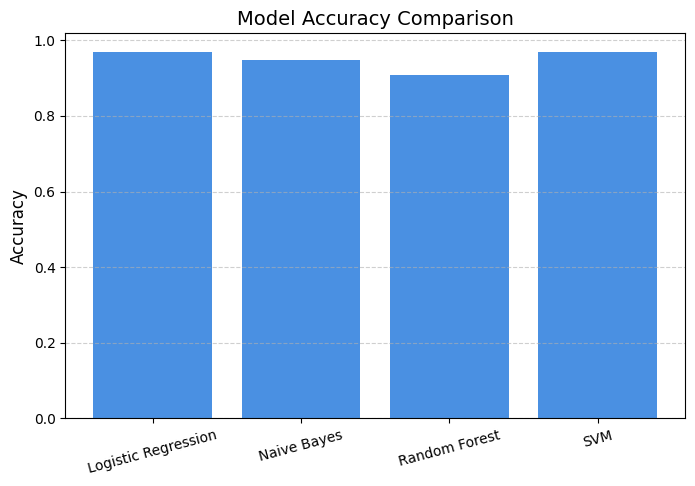


💾 Saving best model ...
✅ Saved 'Logistic Regression' as best_complaint_model.pkl


In [9]:
import time
import warnings
import matplotlib.pyplot as plt
import joblib
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# ---------------------------------------------------------------
# Define models (balanced for speed & performance)
# ---------------------------------------------------------------
models = {
    "Logistic Regression": LogisticRegression(
        random_state=42, solver="liblinear", C=10.0, max_iter=500
    ),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(
        random_state=42, n_estimators=50, max_depth=15, n_jobs=-1
    ),
    "SVM": LinearSVC(random_state=42, max_iter=2000)
}

results = {}
reports = {}

# ---------------------------------------------------------------
# Train & Evaluate Each Model
# ---------------------------------------------------------------
for name, model in models.items():
    print(f"\n🚀 Training {name} ...")
    start_time = time.time()

    # Create a TF-IDF + Model pipeline
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(stop_words="english", max_features=20000, ngram_range=(1, 2))),
        ("model", model)
    ])

    # Fit on training data
    pipeline.fit(X_train, y_train)

    # Predict on test data
    y_pred = pipeline.predict(X_test)

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    reports[name] = classification_report(y_test, y_pred)

    print(f"✅ Accuracy for {name}: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    print(f"⏱ Completed in {time.time() - start_time:.2f} sec")

# ---------------------------------------------------------------
# Summary Table
# ---------------------------------------------------------------
print("\n==============================")
print("🏆 Model Accuracy Summary")
print("==============================")
for model, acc in results.items():
    print(f"{model:20s} : {acc:.4f}")

best_model_name = max(results, key=results.get)
print(f"\n🥇 Best Model: {best_model_name} with accuracy {results[best_model_name]:.4f}")

# ---------------------------------------------------------------
# Visualization
# ---------------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.bar(results.keys(), results.values(), color="#4A90E2")
plt.title("Model Accuracy Comparison", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# ---------------------------------------------------------------
# Save Best Model
# ---------------------------------------------------------------
print("\n💾 Saving best model ...")
best_model = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", max_features=20000, ngram_range=(1, 2))),
    ("model", models[best_model_name])
])
best_model.fit(X_train, y_train)

joblib.dump(best_model, "best_complaint_model.pkl")
print(f"✅ Saved '{best_model_name}' as best_complaint_model.pkl")

#  6. Prediction 

In [10]:
new_complaints = [
    "I am being charged an incorrect fee on my mortgage payment.",
    "This company keeps calling my family about a debt I don't recognize.",
    "I looked at my credit report and there is a fraudulent account open.",
    "I applied for a car loan and was denied without a clear reason."
]

# Use the trained pipeline to predict
predicted_labels = pipeline.predict(new_complaints)

# Use the same reverse_category_map to convert IDs to names
predicted_categories = [reverse_category_map[p] for p in predicted_labels]

print("\nPrediction Results:")
for complaint, category in zip(new_complaints, predicted_categories):
    print(f"\nComplaint: '{complaint[:70]}...'\nPredicted: '{category}'")


Prediction Results:

Complaint: 'I am being charged an incorrect fee on my mortgage payment....'
Predicted: 'Mortgage'

Complaint: 'This company keeps calling my family about a debt I don't recognize....'
Predicted: 'Debt collection'

Complaint: 'I looked at my credit report and there is a fraudulent account open....'
Predicted: 'Debt collection'

Complaint: 'I applied for a car loan and was denied without a clear reason....'
Predicted: 'Consumer Loan'
